# Using Simple Dataset

In [ ]:
import numpy as np
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.losses import sparse_categorical_crossentropy
from tensorflow.python.keras.callbacks import ModelCheckpoint
import os
import io
from google.colab import files
import requests

In [ ]:
french_raw = pd.read_csv("https://raw.githubusercontent.com/tommytracey/AIND-Capstone/master/data/small_vocab_fr",delimiter="\t", header=None)
english_raw = pd.read_csv("https://raw.githubusercontent.com/tommytracey/AIND-Capstone/master/data/small_vocab_en",delimiter="\t", header=None)

In [ ]:
df = pd.concat((english_raw, french_raw), axis=1)
df.columns = ['english', 'french']

In [ ]:
punctuations = string.punctuation
def remove_punctuations(sentence):
    result = list()
    for word in sentence.split():
        if (word in punctuations):
            pass
        else:
            result.append(word.lower())
    return result

In [ ]:
df['english_clean'] = df['english'].map(remove_punctuations)
df['french_clean'] = df['french'].map(remove_punctuations)

In [ ]:
english_clean = list(df['english_clean'].to_numpy())
french_clean = list(df['french_clean'].to_numpy())

In [ ]:
english_clean = [' '.join(sentence) for sentence in english_clean]
french_clean = [' '.join(sentence) for sentence in french_clean]

In [ ]:
english_len = [len(sentence.split()) for sentence in english_clean]
french_len = [len(sentence.split()) for sentence in french_clean]

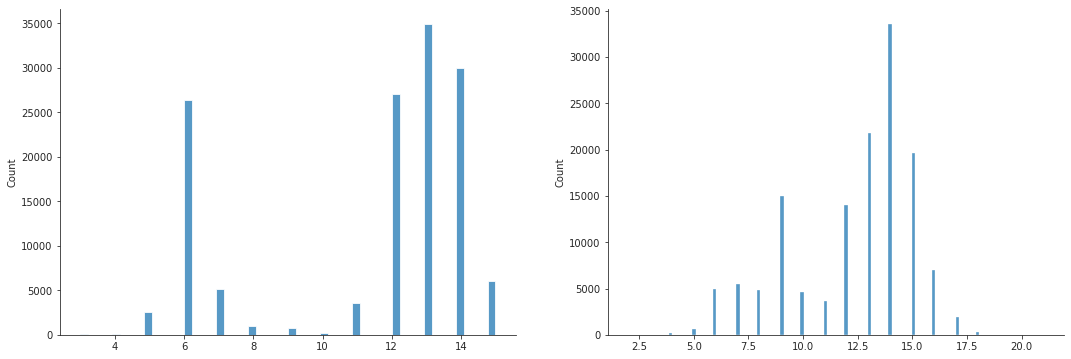

In [ ]:
sns.set_style('ticks')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

sns.histplot(english_len, ax=ax[0])
sns.histplot(french_len, ax=ax[1])
sns.despine()
plt.show()

In [ ]:
eng_length = 20
frn_length = 20

In [ ]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [ ]:
eng_tokenizer = tokenization(english_clean)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

In [ ]:
frn_tokenizer = tokenization(french_clean)
frn_vocab_size = len(frn_tokenizer.word_index) + 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(english_clean, french_clean, test_size=0.25, random_state=8)

In [ ]:
Xtrain = encode_sequences(eng_tokenizer, eng_length, X_train)
ytrain = encode_sequences(frn_tokenizer, frn_length, y_train)

In [ ]:
Xtest = encode_sequences(eng_tokenizer, eng_length, X_test)
ytest = encode_sequences(frn_tokenizer, frn_length, y_test)

In [ ]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
model = build_model(eng_vocab_size, frn_vocab_size, eng_length, frn_length, 512)

In [ ]:
rms = tf.optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
filename = 'model_trial1_jul22'
checkpoint = ModelCheckpoint(filename, monitor='accuracy', verbose=1, save_best_only=True, mode='min')
history = model.fit(Xtrain, ytrain.reshape(ytrain.shape[0], ytrain.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)  

Epoch 1/30
162/162 [==============================] - 51s 268ms/step - loss: 2.5133 - accuracy: 0.4509 - val_loss: 1.8646 - val_accuracy: 0.5296

Epoch 00001: accuracy improved from inf to 0.45094, saving model to model_trial1_jul22
INFO:tensorflow:Assets written to: model_trial1_jul22/assets
Epoch 2/30
162/162 [==============================] - 43s 267ms/step - loss: 1.6823 - accuracy: 0.5572 - val_loss: 1.3243 - val_accuracy: 0.6416

Epoch 00002: accuracy did not improve from 0.45094
Epoch 3/30
162/162 [==============================] - 44s 272ms/step - loss: 1.2176 - accuracy: 0.6583 - val_loss: 1.1571 - val_accuracy: 0.6607

Epoch 00003: accuracy did not improve from 0.45094
Epoch 4/30
162/162 [==============================] - 42s 262ms/step - loss: 0.9278 - accuracy: 0.7239 - val_loss: 0.8754 - val_accuracy: 0.7371

Epoch 00004: accuracy did not improve from 0.45094
Epoch 5/30
162/162 [==============================] - 44s 269ms/step - loss: 0.7332 - accuracy: 0.7752 - val_loss: 

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 512)           102400    
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 20, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 512)           2099200   
_________________________________________________________________
dense (Dense)                (None, 20, 345)           176985    
Total params: 4,477,785
Trainable params: 4,477,785
Non-trainable params: 0
_________________________________________________________________
None


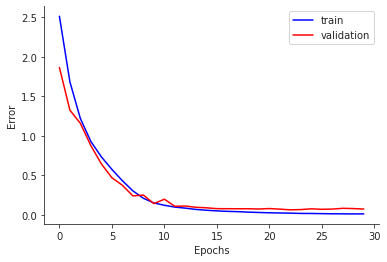

In [ ]:
sns.set_style('ticks')
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')
sns.despine()
plt.legend(['train','validation'])
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [ ]:
preds = []

for i in range(15):
  preds.append(model.predict_classes(Xtest[i].reshape(1, 20)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:

from nltk.translate.bleu_score import sentence_bleu
for i in range(100,105):
    original = ' '.join([word for word in german_sentences[i:i+1][0]])
    references = ' '.join([word for word in english_sentences[i:i+1][0]])
    candidates = logits_to_text(model.predict(preproc_german_sentences[i:i+1])[0], english_tokenizer)
    score = sentence_bleu(references, candidates)
    print('\nGER: ', original)
    print('ENG: ', references)
    print('Pred: ', candidates)
    print('BLEU score:', score)

In [ ]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
      for k in i[j]:
        t = get_word(k, frn_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
Xtest[:15]

array([[ 97,  92,  28,  77,   7,  80,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 32,  12,  16,  13,   1,   5,  91,   6,  49,  12,  16,   1,   5,
         90,   0,   0,   0,   0,   0,   0],
       [ 24,   1,   9,  52,   4,  36,   7,   3,   1,   8,  68,   2,  40,
          0,   0,   0,   0,   0,   0,   0],
       [ 26,  70,  73,  74,   7,  72,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 25,   1,   8,  67,   4,  39,   6,   3,   1,   8,  41,   2,  37,
          0,   0,   0,   0,   0,   0,   0],
       [ 24,   1,   8,  68,   4,  42,   6,   3,   1,   9,  51,   2,  44,
          0,   0,   0,   0,   0,   0,   0],
       [  5,  20,  21,   1,  56,   4,  54,   7,   3,   1,  59,   2,  48,
          0,   0,   0,   0,   0,   0,   0],
       [  5,  20,  21,   1,   8,  62,   4,  45,   7,   3,   1,   9,  63,
          2,  42,   0,   0,   0,   0,   0],
       [ 26, 136, 106,  81,  24, 105,  46,   0,   0,   0,   0,  

In [ ]:
actual_text = []
for i in Xtest[:15]:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    actual_text.append(' '.join(temp))

In [ ]:
actual_text

['we like grapefruit oranges and bananas              ',
 'her least liked fruit is the peach but our least liked is the strawberry      ',
 'france is usually pleasant during january and it is sometimes hot in may       ',
 'he likes grapes mangoes and lemons              ',
 'china is sometimes quiet during autumn but it is sometimes nice in winter       ',
 'france is sometimes hot during september but it is usually freezing in april       ',
 'the united states is warm during october and it is dry in february       ',
 'the united states is sometimes chilly during november and it is usually rainy in september     ',
 'he might go to france next summer             ',
 'france is sometimes busy during summer but it is never pleasant in fall       ',
 'she likes big apples                ',
 'france is never warm during february and it is never pleasant in december       ',
 'the apple is our most loved fruit but the grapefruit is his most loved      ',
 'new jersey is wet during autu

In [ ]:
preds_text

['nous aimons le pamplemousse les oranges et les bananes           ',
 'son fruit est moins aimé la pêche mais notre moins aimé est la fraise      ',
 'la france est généralement agréable en janvier et il est parfois chaud en mai      ',
 'il aime les raisins les et citrons             ',
 "chine est parfois calme pendant l' automne mais il est parfois agréable en hiver      ",
 'la france est parfois chaud en septembre mais il gèle habituellement en avril       ',
 'les états unis est chaud en octobre et il est sec en février       ',
 'les états unis est parfois froid en novembre et il est généralement pluvieux en septembre     ',
 "il pourrait aller en france l' été prochain            ",
 "la france est parfois occupé pendant l' été mais il est jamais agréable à l' automne    ",
 'elle aime les pommes                ',
 'la france est jamais chaud au mois de février et il est jamais agréable en décembre    ',
 'la pomme est le fruit le plus aimé notre mais le pamplemousse est le pl

In [ ]:
y_test[:15]

['nous aimons le pamplemousse les oranges et les bananes',
 'son fruit est moins aimé la pêche mais notre moins aimé est la fraise',
 'la france est généralement agréable en janvier et il est parfois chaud en mai',
 'il aime les raisins mangues et citrons',
 "chine est parfois calme pendant l' automne mais il est parfois agréable en hiver",
 'la france est parfois chaud en septembre mais il gèle habituellement en avril',
 'les états-unis est chaud en octobre et il est sec en février',
 'les états-unis est parfois froid en novembre et il est généralement pluvieux en septembre',
 "il pourrait aller en france l' été prochain",
 "la france est parfois occupé pendant l' été mais il est jamais agréable à l' automne",
 'elle aime grosses pommes',
 'la france est jamais chaud au mois de février et il est jamais agréable en décembre',
 'la pomme est le fruit le plus aimé notre mais le pamplemousse est le plus aimé',
 "new jersey est humide à l'automne mais il est jamais occupé en janvier",
 'ca

# Using More Complex Dataset

In [ ]:
all = pd.read_csv("https://raw.githubusercontent.com/devm2024/nmt_keras/master/fra.txt", delimiter="\t", header=None)

In [ ]:
all.columns = ['english', 'french']

In [ ]:
all['english_clean'] = all['english'].map(remove_punctuations)
all['french_clean'] = all['french'].map(remove_punctuations)

In [ ]:
english_clean = list(all['english_clean'].to_numpy())
french_clean = list(all['french_clean'].to_numpy())

In [ ]:
english_clean = [' '.join(sentence) for sentence in english_clean]
french_clean = [' '.join(sentence) for sentence in french_clean]

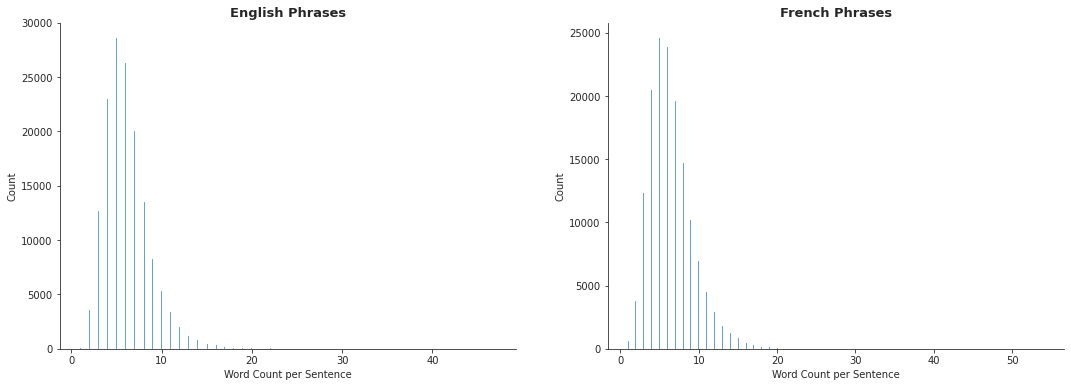

In [ ]:
english_len = [len(sentence.split()) for sentence in english_clean]
french_len = [len(sentence.split()) for sentence in french_clean]

sns.set_style('ticks')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

sns.histplot(english_len, ax=ax[0])
ax[0].set(xlabel="Word Count per Sentence")
ax[0].set_title('English Phrases', fontweight='bold', fontsize=13)
sns.histplot(french_len, ax=ax[1])
ax[1].set(xlabel='Word Count per Sentence')
ax[1].set_title('French Phrases', fontweight='bold', fontsize=13)
sns.despine()
plt.show()

In [ ]:
eng_length = 20
frn_length = 20

eng_tokenizer = tokenization(english_clean)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

frn_tokenizer = tokenization(french_clean)
frn_vocab_size = len(frn_tokenizer.word_index) + 1

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(english_clean, french_clean, test_size=0.25, random_state=8)

Xtrain = encode_sequences(eng_tokenizer, eng_length, X_train)
ytrain = encode_sequences(frn_tokenizer, frn_length, y_train)

Xtest = encode_sequences(eng_tokenizer, eng_length, X_test)
ytest = encode_sequences(frn_tokenizer, frn_length, y_test)

In [ ]:
print(len(eng_tokenizer.word_index))
print(len(frn_tokenizer.word_index))

13907
26041


In [ ]:
new_model = build_model(eng_vocab_size, frn_vocab_size, eng_length, frn_length, 512)
rms = tf.optimizers.RMSprop(lr=0.001)
new_model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
filename = 'model_trial1_jul22'
checkpoint = ModelCheckpoint(filename, monitor='accuracy', verbose=1, save_best_only=True, mode='min')
history = new_model.fit(Xtrain, ytrain.reshape(ytrain.shape[0], ytrain.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
176/176 [==============================] - 118s 645ms/step - loss: 2.6308 - accuracy: 0.6741 - val_loss: 2.2846 - val_accuracy: 0.6842

Epoch 00001: accuracy improved from inf to 0.67412, saving model to model_trial1_jul22
INFO:tensorflow:Assets written to: model_trial1_jul22/assets
Epoch 2/30
176/176 [==============================] - 115s 654ms/step - loss: 2.1921 - accuracy: 0.6904 - val_loss: 2.1283 - val_accuracy: 0.6943

Epoch 00002: accuracy did not improve from 0.67412
Epoch 3/30
176/176 [==============================] - 115s 654ms/step - loss: 2.0243 - accuracy: 0.7026 - val_loss: 1.9562 - val_accuracy: 0.7112

Epoch 00003: accuracy did not improve from 0.67412
Epoch 4/30
176/176 [==============================] - 115s 654ms/step - loss: 1.8663 - accuracy: 0.7190 - val_loss: 1.8518 - val_accuracy: 0.7228

Epoch 00004: accuracy did not improve from 0.67412
Epoch 5/30
176/176 [==============================] - 115s 654ms/step - loss: 1.7481 - accuracy: 0.7291 - val_l

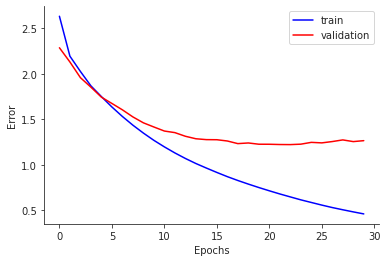

In [ ]:
sns.set_style('ticks')
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')
sns.despine()
plt.legend(['train','validation'])
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

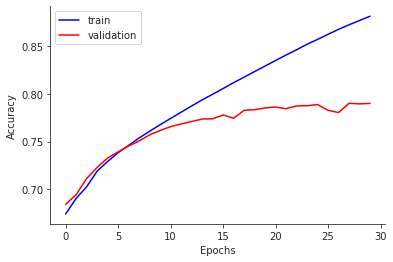

In [ ]:
sns.set_style('ticks')
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='red')
sns.despine()
plt.legend(['train','validation'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
preds = []

for i in range(15):
  preds.append(new_model.predict_classes(Xtest[i].reshape(1, 20)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
      for k in i[j]:
        t = get_word(k, frn_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
preds_text

['le café et thé et en cartes             ',
 "je pense simplement que vous devriez être plus prudent c'est tout         ",
 'avez vous un place dans la barbe en            ',
 "le police l'a fait le voleur              ",
 'tom prit une autre bouchée               ',
 "tom ne savait même pas que j'étais ici            ",
 'il se dépêcha afin ne pas rater le train train          ',
 "ils ne pas pas que je l'examine             ",
 'les ans cinq cinq cinq année année             ',
 "tom nous a demandé de l'aider l'aider             ",
 'arrêtez de parler je vous prie              ',
 "vous avez l'air japonaise                ",
 'la route était la glace pieds              ',
 "même n'y n'y n'y ne ne nous nous nous tout          ",
 'si tu veux parler                ']

In [ ]:
actual_text = []
for i in Xtest[:15]:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    actual_text.append(' '.join(temp))

In [ ]:
actual_text

['coffee please with cream and sugar              ',
 "i just think you should be more careful that's all          ",
 'do you have a crowbar in your toolbox            ',
 'the police caught him at it              ',
 'tom took another bite                ',
 "tom didn't even know i was here             ",
 "he hurried so he wouldn't miss the train            ",
 "they didn't want me to examine it             ",
 'ninety five percent of orphans are older than 5 years old         ',
 'tom has asked us to help him             ',
 'please stop talking                 ',
 'you look japanese                 ',
 'the road was blocked by fallen rocks             ',
 'if it were not for the sun we could not live at all       ',
 'if you want to talk               ']

In [ ]:
y_test[:15]

["du café lait et sucre, s'il vous plaît",
 "je pense simplement que vous devriez être plus prudente, c'est tout.",
 "disposez-vous d'une pince-monseigneur dans votre caisse à outils",
 "la police l'a pris en flagrant délit.",
 'tom a pris une autre bouchée.',
 "tom ne savait même pas que j'étais là.",
 "il s'est dépêché pour ne pas rater le train.",
 "elles ne voulurent pas que je l'examine.",
 'quatre-vingt quinze pour cent des orphelins ont plus de cinq ans.',
 "tom nous a demandé de l'aider.",
 'cessez de parler, je vous prie',
 "tu as l'air japonais.",
 'la route était bloquée par des éboulements de roches.',
 "si ce n'était pas pour le soleil nous ne pourrions pas vivre du tout.",
 'si vous voulez parler, parlez']

Switch to French to English

In [ ]:
eng_length = 20
frn_length = 20

eng_tokenizer = tokenization(english_clean)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

frn_tokenizer = tokenization(french_clean)
frn_vocab_size = len(frn_tokenizer.word_index) + 1

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(french_clean, english_clean, test_size=0.25, random_state=8)

Xtrain = encode_sequences(frn_tokenizer, frn_length, X_train)
ytrain = encode_sequences(eng_tokenizer, eng_length, y_train)

Xtest = encode_sequences(frn_tokenizer, frn_length, X_test)
ytest = encode_sequences(eng_tokenizer, eng_length, y_test)

In [ ]:
switch_model = build_model(frn_vocab_size, eng_vocab_size, frn_length, eng_length, 512)
rms = tf.optimizers.RMSprop(lr=0.001)
switch_model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history_2 = switch_model.fit(Xtrain, ytrain.reshape(ytrain.shape[0], ytrain.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          verbose=1)

Epoch 1/30
176/176 [==============================] - 92s 497ms/step - loss: 2.2783 - accuracy: 0.7018 - val_loss: 2.0276 - val_accuracy: 0.7081
Epoch 2/30
176/176 [==============================] - 87s 494ms/step - loss: 1.9340 - accuracy: 0.7144 - val_loss: 1.9085 - val_accuracy: 0.7164
Epoch 3/30
176/176 [==============================] - 87s 495ms/step - loss: 1.8000 - accuracy: 0.7231 - val_loss: 1.7685 - val_accuracy: 0.7294
Epoch 4/30
176/176 [==============================] - 87s 497ms/step - loss: 1.6564 - accuracy: 0.7387 - val_loss: 1.6123 - val_accuracy: 0.7468
Epoch 5/30
176/176 [==============================] - 87s 496ms/step - loss: 1.5185 - accuracy: 0.7555 - val_loss: 1.4970 - val_accuracy: 0.7603
Epoch 6/30
176/176 [==============================] - 87s 495ms/step - loss: 1.3964 - accuracy: 0.7691 - val_loss: 1.4024 - val_accuracy: 0.7715
Epoch 7/30
176/176 [==============================] - 87s 494ms/step - loss: 1.2805 - accuracy: 0.7807 - val_loss: 1.3194 - val_ac

In [ ]:
print(switch_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 512)           13333504  
_________________________________________________________________
lstm_10 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 20, 512)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 20, 512)           2099200   
_________________________________________________________________
dense_5 (Dense)              (None, 20, 13908)         7134804   
Total params: 24,666,708
Trainable params: 24,666,708
Non-trainable params: 0
_________________________________________________________________
None


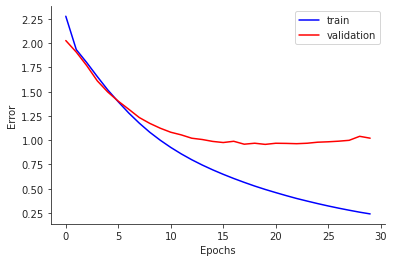

In [ ]:
sns.set_style('ticks')
plt.plot(history_2.history['loss'], color='blue')
plt.plot(history_2.history['val_loss'], color='red')
sns.despine()
plt.legend(['train','validation'])
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

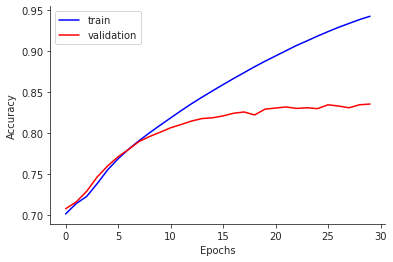

In [ ]:
sns.set_style('ticks')
plt.plot(history_2.history['accuracy'], color='blue')
plt.plot(history_2.history['val_accuracy'], color='red')
sns.despine()
plt.legend(['train','validation'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
preds = []

for i in range(15):
  preds.append(switch_model.predict_classes(Xtest[i].reshape(1, 20)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
      for k in i[j]:
        t = get_word(k, eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
preds_text

['coffee coffee coffee coffee sugar sugar              ',
 'i just think you should be more careful all           ',
 'do you have a small of a in in your          ',
 'the police took the the red              ',
 'tom took another bite                ',
 "tom didn't even know i was there             ",
 "he hurried so he wouldn't wouldn't the train            ",
 "they didn't want me to examine it             ",
 'there than hundred hundred more more four years years years years         ',
 'tom asked us to help for              ',
 'please stop talking                 ',
 'you look japanese                 ',
 'the road was by to be down down foot           ',
 "if were were not water we we wouldn't wouldn't be          ",
 'if you want to talk talk              ']

In [ ]:
actual_text = []
for i in Xtest[:15]:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], frn_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], frn_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    actual_text.append(' '.join(temp))

In [ ]:
actual_text

["du café lait et sucre s'il vous plaît            ",
 "je pense simplement que vous devriez être plus prudente c'est tout         ",
 "disposez vous d'une pince monseigneur dans votre caisse à outils          ",
 "la police l'a pris en flagrant délit             ",
 'tom a pris une autre bouchée              ',
 "tom ne savait même pas que j'étais là            ",
 "il s'est dépêché pour ne pas rater le train           ",
 "elles ne voulurent pas que je l'examine             ",
 'quatre vingt quinze pour cent des orphelins ont plus de cinq ans        ',
 "tom nous a demandé de l'aider              ",
 'cessez de parler je vous prie              ',
 "tu as l'air japonais                ",
 'la route était bloquée par des éboulements de roches           ',
 "si ce n'était pas pour le soleil nous ne pourrions pas vivre du tout      ",
 'si vous voulez parler parlez               ']

In [ ]:
y_test[:15]

['coffee, please, with cream and sugar.',
 "i just think you should be more careful, that's all.",
 'do you have a crowbar in your toolbox?',
 'the police caught him at it.',
 'tom took another bite.',
 "tom didn't even know i was here.",
 "he hurried so he wouldn't miss the train.",
 "they didn't want me to examine it.",
 'ninety-five percent of orphans are older than 5 years old.',
 'tom has asked us to help him.',
 'please stop talking.',
 'you look japanese.',
 'the road was blocked by fallen rocks.',
 'if it were not for the sun, we could not live at all.',
 'if you want to talk, talk.']

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,15):
    original = X_test[i]
    references = y_test[i]
    candidates = preds_text[i]
    score = sentence_bleu(references, candidates)
    print('\nFRE: ', original)
    print('ENG: ', references)
    print('Pred: ', candidates)
    print('BLEU score:', score)


FRE:  du café lait et sucre, s'il vous plaît
ENG:  coffee, please, with cream and sugar.
Pred:  coffee coffee coffee coffee sugar sugar              
BLEU score: 0.6590692245607205

FRE:  je pense simplement que vous devriez être plus prudente, c'est tout.
ENG:  i just think you should be more careful, that's all.
Pred:  i just think you should be more careful all           
BLEU score: 0.7801157731069053

FRE:  disposez-vous d'une pince-monseigneur dans votre caisse à outils
ENG:  do you have a crowbar in your toolbox?
Pred:  do you have a small of a in in your          
BLEU score: 0.7331329005620809

FRE:  la police l'a pris en flagrant délit.
ENG:  the police caught him at it.
Pred:  the police took the the red              
BLEU score: 0.6844861471686758

FRE:  tom a pris une autre bouchée.
ENG:  tom took another bite.
Pred:  tom took another bite                
BLEU score: 0.7546487907970829

FRE:  tom ne savait même pas que j'étais là.
ENG:  tom didn't even know i was here.
Pr

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
def build_new_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(Bidirectional(GRU(units)))
    model.add(RepeatVector(out_timesteps))
    model.add(Bidirectional(GRU(units, return_sequences=True)))
    model.add(TimeDistributed(Dense(out_vocab, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model

In [ ]:
switch_model2 = build_new_model(frn_vocab_size, eng_vocab_size, frn_length, eng_length, 512)
#rms = tf.optimizers.RMSprop(lr=0.001)
switch_model2.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def build_model2(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(Bidirectional(GRU(units)))
    model.add(RepeatVector(out_timesteps))
    model.add(Bidirectional(GRU(units, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
switch_model2 = build_model2(frn_vocab_size, eng_vocab_size, frn_length, eng_length, 512)
#rms = tf.optimizers.RMSprop(lr=0.001)
switch_model2.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history3 = switch_model2.fit(Xtrain, ytrain.reshape(ytrain.shape[0], ytrain.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          verbose=1)

Epoch 1/30
176/176 [==============================] - 158s 855ms/step - loss: 2.3769 - accuracy: 0.6997 - val_loss: 1.9858 - val_accuracy: 0.7100
Epoch 2/30
176/176 [==============================] - 150s 851ms/step - loss: 1.9408 - accuracy: 0.7131 - val_loss: 1.9085 - val_accuracy: 0.7177
Epoch 3/30
176/176 [==============================] - 150s 853ms/step - loss: 1.8499 - accuracy: 0.7204 - val_loss: 1.8172 - val_accuracy: 0.7240
Epoch 4/30
176/176 [==============================] - 150s 852ms/step - loss: 1.7250 - accuracy: 0.7312 - val_loss: 1.6926 - val_accuracy: 0.7370
Epoch 5/30
176/176 [==============================] - 149s 849ms/step - loss: 1.5841 - accuracy: 0.7468 - val_loss: 1.5697 - val_accuracy: 0.7530
Epoch 6/30
176/176 [==============================] - 149s 848ms/step - loss: 1.4520 - accuracy: 0.7606 - val_loss: 1.4614 - val_accuracy: 0.7654
Epoch 7/30
176/176 [==============================] - 150s 851ms/step - loss: 1.3252 - accuracy: 0.7726 - val_loss: 1.3634 -

In [ ]:
print(switch_model2.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 20, 512)           13333504  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              3148800   
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 20, 1024)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20, 1024)          4721664   
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 1024)          0         
_________________________________________________________________
dense_13 (Dense)             (None, 20, 13908)         14255700  
Total params: 35,459,668
Trainable params: 35,459,668
Non-trainable params: 0
_________________________________________

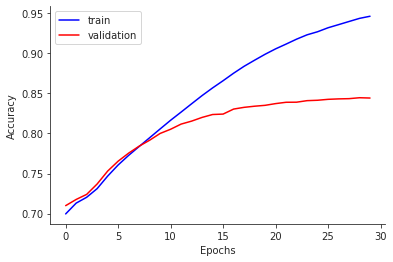

In [ ]:
sns.set_style('ticks')
plt.plot(history3.history['accuracy'], color='blue')
plt.plot(history3.history['val_accuracy'], color='red')
sns.despine()
plt.legend(['train','validation'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

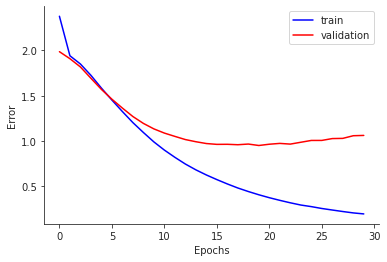

In [ ]:
sns.set_style('ticks')
plt.plot(history3.history['loss'], color='blue')
plt.plot(history3.history['val_loss'], color='red')
sns.despine()
plt.legend(['train','validation'])
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()